# Chest X-Ray Medical Diagnosis with Deep Learning(17 desease)

In [1]:
# Import necessary packages
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.layers import Dense
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.metrics import binary_accuracy
from keras.preprocessing import image

from keras.models import Model

from keras.optimizers import Adam
from keras.optimizers import AdamW
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Import Densenet from Keras
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")
sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

## Data Exploration
#### Coupling of data sets
The maximum number of images related to 13 lung diseases (Atelectasis, Cardiomegaly, Effusion, Infiltrate, Mass, Nodule, Pneumothorax, Consolidation, Edema, Emphysema, Fibrosis, Pleural Thickening, and Hernia) were collected from the ChestX-Ray14 dataset.The CXR images of pneumonia from the ChestX-Ray14 were not considered since the difference between viral and bacterial pneumonia was not distinctive enough. Therefore, the CXR images of viral and bacterial pneumonia were collected from the Kaggle pneumonia dataset link:[Kaggle pneumonia dataset](https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis)
 It should be noted that large number of COVID-19 CXR images were not available in a single publicly open dataset, hence numerous datasets were integrated to construct.[Covid 19](https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset)
 Finally,  3499 CXR images of tuberculosis (TB) were gathered from three separate datasets[TB](https://www.kaggle.com/datasets/scipygaurav/tuberculosis-tb-chest-x-ray-cleaned-database) to complete the construction of a unique dataset that contains a total of seventeen lung diseases with 45,347 CXR images (CXR17)
 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset CSV file
csv_file_path = '/kaggle/input/newdataset/cleaned_file.csv'  # Adjust the path if necessary
df = pd.read_csv(csv_file_path)

# Split dataset into 70% training, 15% validation, and 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 30% for validation + test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp_df evenly

# Print the number of rows in each split to verify
print(f"Train DataFrame: {train_df.shape[0]} rows")
print(f"Validation DataFrame: {val_df.shape[0]} rows")
print(f"Test DataFrame: {test_df.shape[0]} rows")



# Optionally, inspect the first few rows of each split
print("\nTrain DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(val_df.head())

print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame: 31741 rows
Validation DataFrame: 6802 rows
Test DataFrame: 6802 rows

Train DataFrame:
            Image Index  Atelectasis  Cardiomegaly  Consolidation  Edema  \
25952  00020725_017.png            0             0              0      0   
37089  COVID19(194).png            0             0              0      0   
24172  00013924_000.png            0             0              0      0   
6754   00001437_034.png            0             0              0      0   
37227  COVID19(318).png            0             0              0      0   

       Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
25952         0          0         0       0             0     0       0   
37089         0          0         0       0             0     0       0   
24172         0          0         0       0             0     0       1   
6754          0          1         0       0             1     0       0   
37227         0          0         0       0             0 

## Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [3]:
#For cheaking data leakage
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 
    
    ### END CODE HERE ###
    
    return leakage

In [4]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'Image Index')))
print("leakage between valid and test: {}".format(check_for_leakage(val_df, test_df, 'Image Index')))

leakage between train and test: False
leakage between valid and test: False


## Explore data labels
Create a list of the names of each patient condition or disease.

In [3]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image Index', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax', 'COVID-19', 'Tuberculosis', 'Viral Pneumonia', 'Bacterial Pneumonia']


In [5]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening','Pneumothorax','COVID-19','Tuberculosis','Viral Pneumonia','Bacterial Pneumonia']


In [6]:
import pandas as pd

# Load the CSV file
csv_path = '/kaggle/input/newdataset/cleaned_file.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_path)

# Drop the 'Image Index' column to focus on the disease labels
disease_labels = df.drop(columns=['Image Index'])

# Calculate the sample count for each disease
disease_counts = disease_labels.sum()

# Print the sample count for each disease
print("Sample count for each disease:")
print(disease_counts)

Sample count for each disease:
Atelectasis            6724
Cardiomegaly           2115
Consolidation          3432
Edema                  1628
Effusion               6202
Emphysema              2086
Fibrosis               1406
Hernia                  194
Infiltration           9637
Mass                   4709
Nodule                 5196
Pleural_Thickening     2646
Pneumothorax           4332
COVID-19               2279
Tuberculosis           3499
Viral Pneumonia        1493
Bacterial Pneumonia    2780
dtype: int64


## Data Visualization

### show positive freq of each class

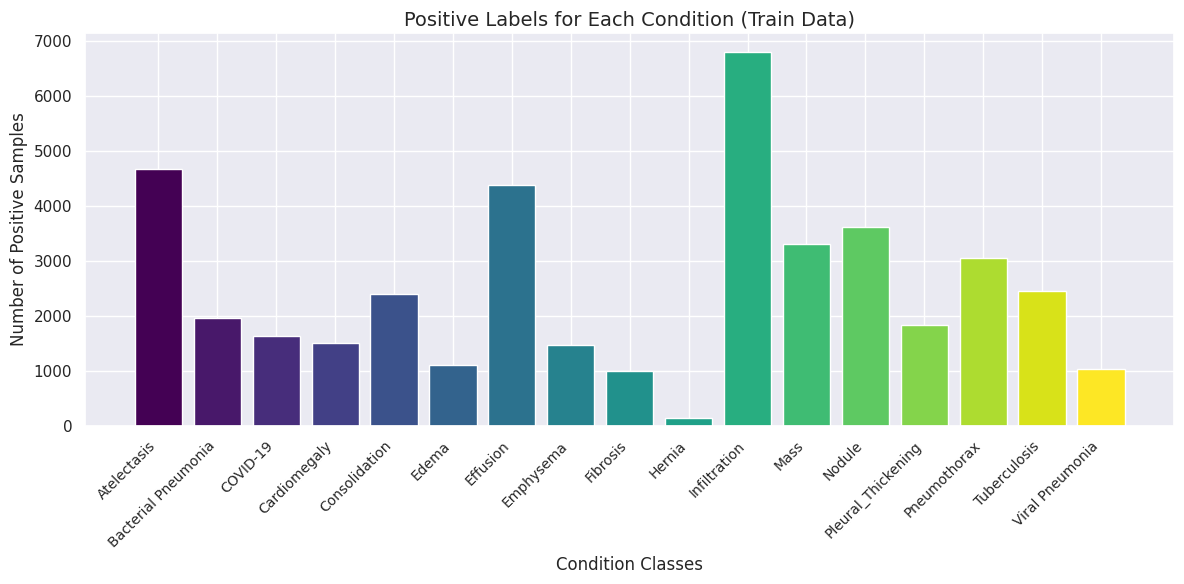

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude 'Image Index' from the columns
columns = train_df.columns.difference(['Image Index'])

# Count positive samples for each condition
positive_counts = [train_df[column].sum() for column in columns]

# Convert columns to strings (ensuring all labels are valid)
columns = [str(col) for col in columns]

# Generate a color for each class using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(columns)))

# Create the bar graph
plt.figure(figsize=(12, 6))
plt.bar(columns, positive_counts, color=colors)
plt.xlabel('Condition Classes', fontsize=12)
plt.ylabel('Number of Positive Samples', fontsize=12)
plt.title('Positive Labels for Each Condition (Train Data)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


### Investigate Correlation Matrix for Label Columns

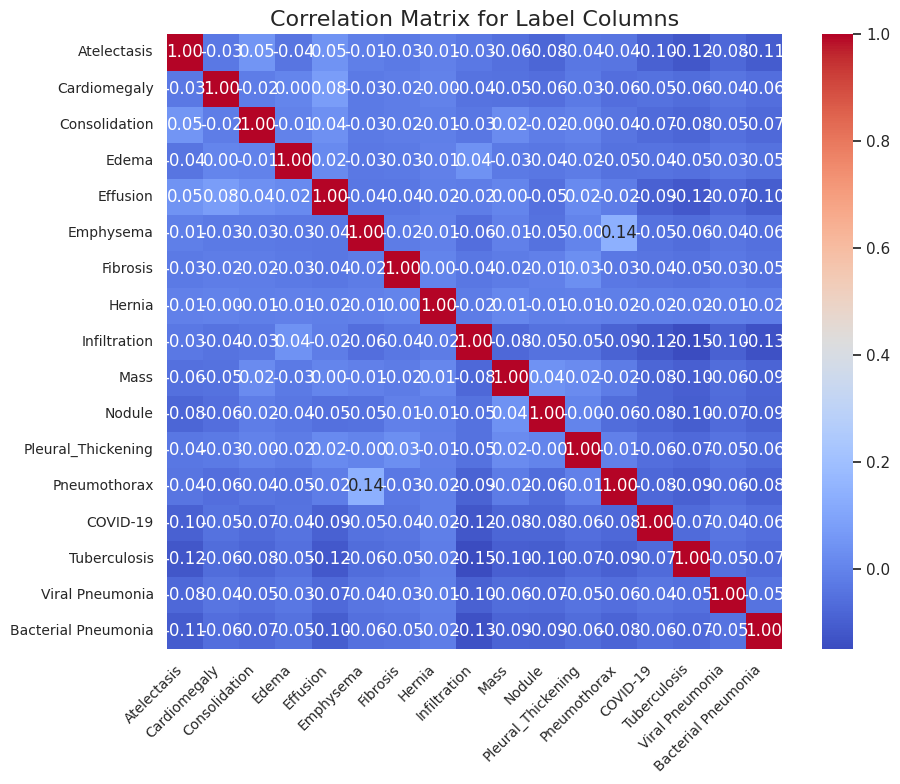

In [9]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df is your DataFrame
# Calculate the correlation matrix for the label columns
correlation_matrix = train_df[labels].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Correlation Matrix for Label Columns', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

### Display Random Images

Display Random Images


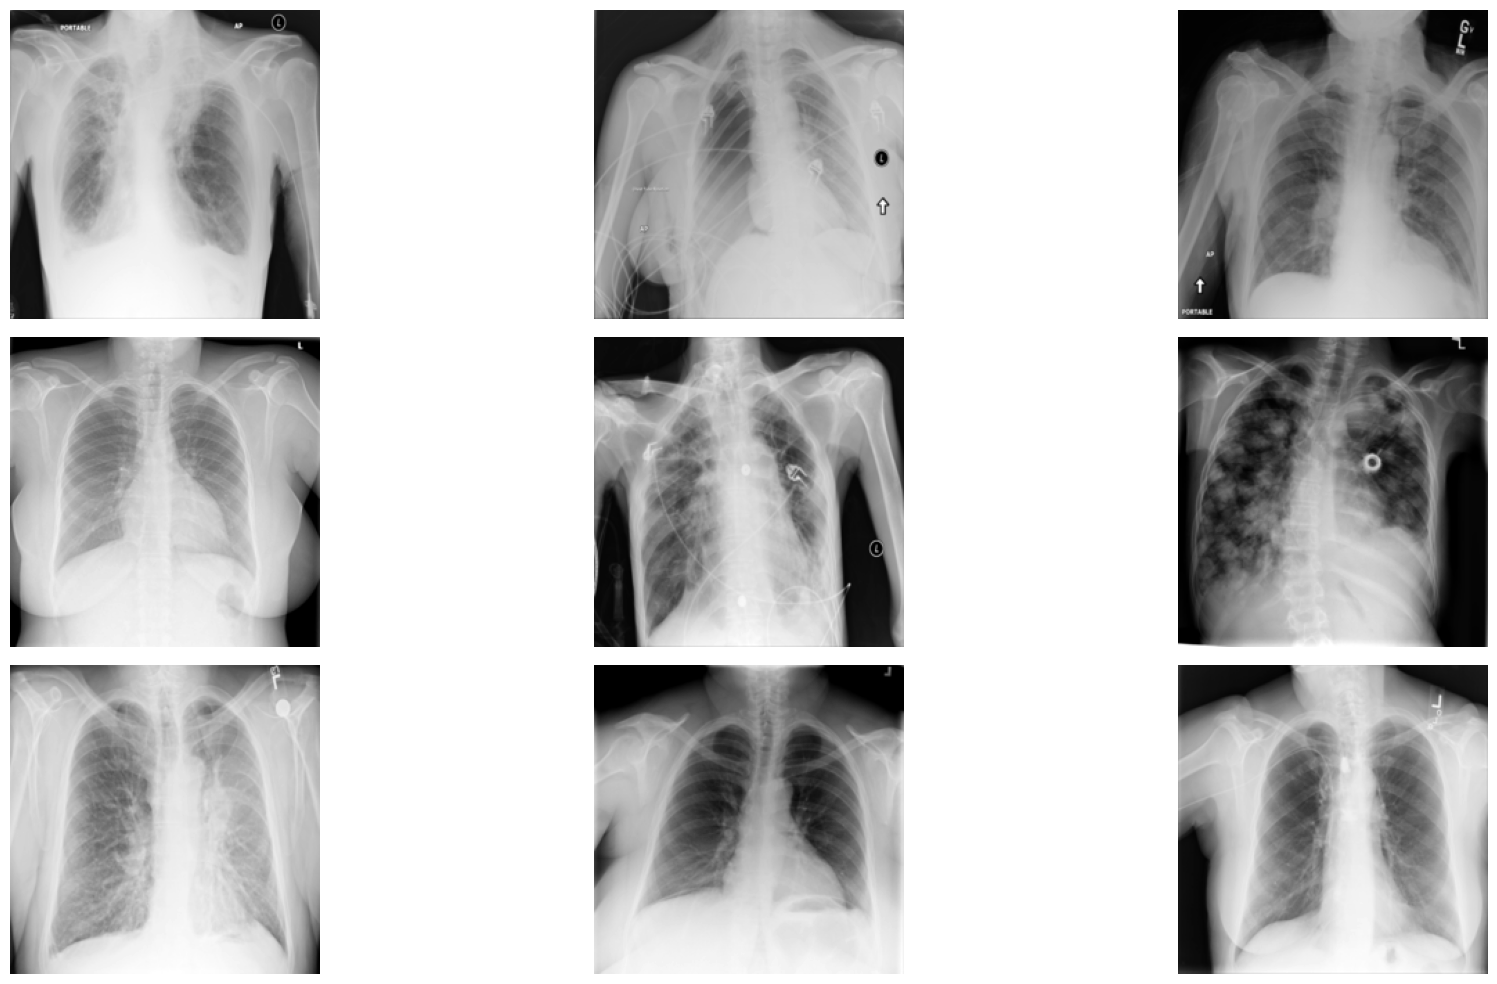

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Extract numpy values from the Image Index column in the data frame
images = train_df['Image Index'].values

# Extract 9 random images
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image directory
img_dir = '/kaggle/input/images/cleanimagefolder'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20, 10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(img_dir, random_images[i])
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.show()


### Investigate a single image
Look at the first image in the dataset and print out some details of the image contents.

The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel
The maximum pixel value is 0.9216 and the minimum is 0.0000
The mean value of the pixels is 0.4852 and the standard deviation is 0.2489


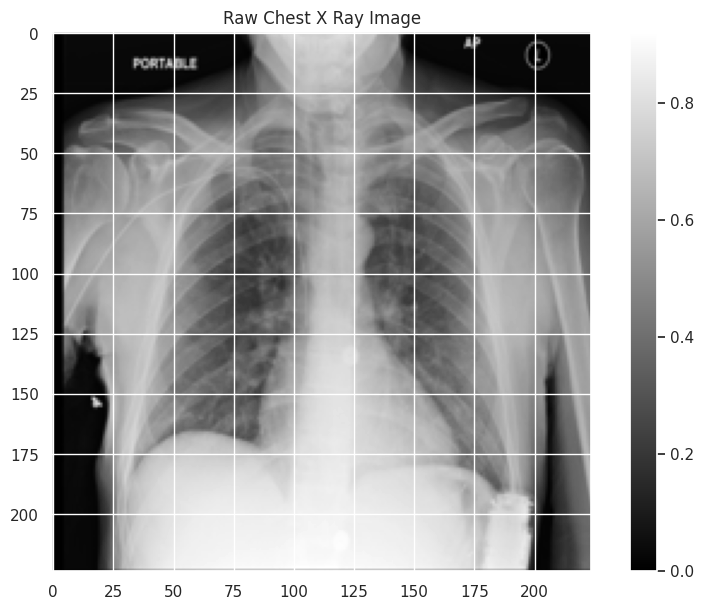

In [11]:
#train_df = train_df.reset_index(drop=True)

# Get the first image that was listed in the train_df dataframe
sample_img = train_df.iloc[0]['Image Index']
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Investigate pixel value distribution
Plot up the distribution of pixel values in the image shown above.

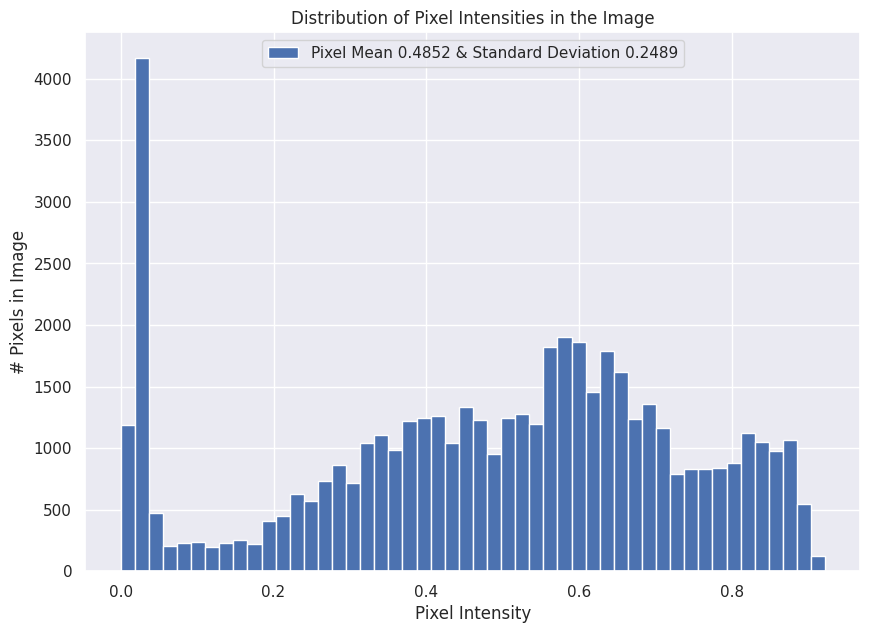

In [12]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

## Image Preprocessing with Normalization
This code defines a custom preprocessing function, preprocess_image, to normalize images for deep learning models, using ImageNet's standard mean and standard deviation values. The mean ([0.485, 0.456, 0.406]) and standard deviation ([0.229, 0.224, 0.225]) are based on the ImageNet dataset, ensuring compatibility with pretrained models. The function first scales the input image to a range of [0, 1] by dividing pixel values by 255.0. Then, it normalizes each pixel by subtracting the mean and dividing by the standard deviation, effectively standardizing the image data. While additional steps like grayscale conversion and contrast enhancement using CLAHE are present in the code as comments, these are optional and not applied in the current implementation. This preprocessing is essential for preparing images to align with the input requirements of ImageNet-trained models.

In [9]:
import numpy as np
# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(2, 2))
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Apply CLAHE to the image
    #claheimage = clahe.apply(img)
    img = img / 255.0
    img = (img - mean) / std
    return img

## Data augmentation and Preprocessing
train data generator & val_generator for training a deep learning model on images, applying real-time data augmentation and preprocessing to improve model generalization and ensure compatibility with pretrained architectures. It starts by setting the image directory IMAGE_DIR, which contains resized 224x224 images for efficient model input. The data augmentation applied to the images includes random horizontal flipping, vertical and horizontal shifting, small rotations, shear transformations, and zooming. These augmentations help the model become more robust to various image distortions and positional changes. The custom preprocess_image function normalizes the images using ImageNet's mean and standard deviation values, which is commonly required for models pretrained on ImageNet.

The generator is configured to take the train_df DataFrame for both the image metadata and labels. The x_col is set to 'Image Index', which points to the image filenames, while the y_col specifies the labels for the diseases. The images are resized to 224x224 pixels, loaded in RGB format, and processed as raw labels for multi-label classification. A batch size of 64 is used to speed up processing, and shuffling is disabled to maintain the order of data. This setup efficiently prepares the images for training and ensures the generator handles large datasets without consuming too much memory.

In [10]:
# Update the train generator with the high batch size
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"
train_generator = ImageDataGenerator(
    samplewise_center=False, 
    samplewise_std_normalization=False, 
    horizontal_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.05,
    rotation_range=5, 
    shear_range=0.1,
    zoom_range=0.05,    
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,  # Using the correct image directory
    x_col='Image Index',  # Correcting x_col to 'id' as per your dataset
    y_col=labels,
    target_size=(224, 224),  # Resize images to 224x224
    color_mode='rgb',  # Load images in RGB color mode
    class_mode='raw',  # Multi-output, raw labels (binary vector for each image)
    batch_size=64,  # Use a larger batch size for faster processing
    shuffle=False  # Ensure data order is consistent
)

Found 31714 validated image filenames.


In [11]:
# Define the directory where images are stored
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"

# Updated validation generator
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image  # Custom preprocessing function
).flow_from_dataframe(
    dataframe=val_df,  # Use the validation DataFrame
    directory=IMAGE_DIR,  # Use the image directory for validation images
    x_col='Image Index',  # Correcting x_col to 'id' as per your dataset
    y_col=labels,
    target_size=(224, 224),  # Resize images to 224x224
    color_mode='rgb',  # Load images in RGB color mode
    class_mode='raw',  # Multi-output, raw labels (binary vector for each image)
    batch_size=64  # Batch size
)

Found 6800 validated image filenames.


### Comparision of preprocess image vs original image

The dimensions of the image are 224 pixels width and 224 pixels height
The maximum pixel value is 2.2853 and the minimum is -2.1179
The mean value of the pixels is 0.2101 and the standard deviation is 1.0993


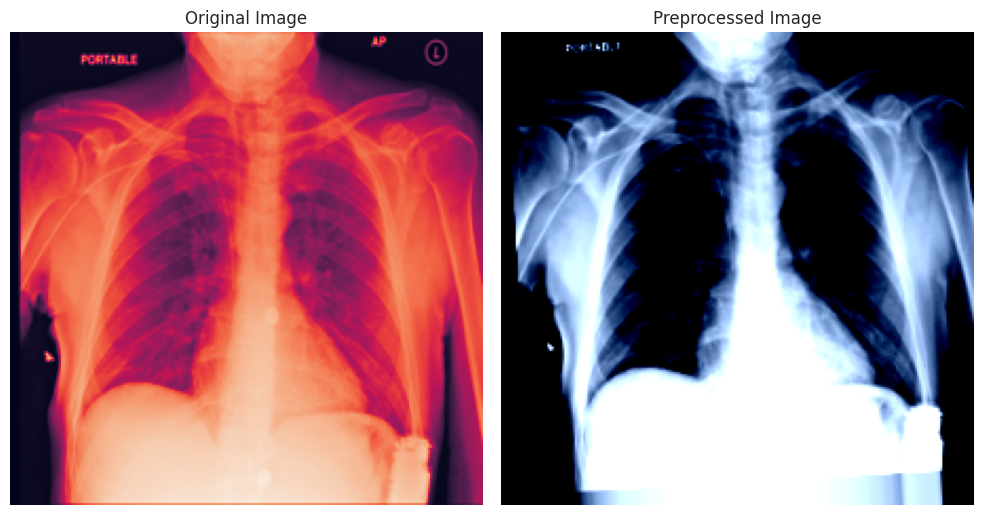

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming the train_generator has been defined earlier as shown

# Get a single batch of images and labels
sample_batch, _ = next(train_generator)  # _ is the corresponding labels

# Choose a random image from the batch
generated_image = sample_batch[0]

# Print image information
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[0]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

# Plot the original and preprocessed images
#plt.figure(figsize=(12, 6))

# Display the original (before preprocessing) image
plt.subplot(1, 2, 1)
# Read the raw image using the path from 'train_df' to show the original
image_path = os.path.join(IMAGE_DIR, train_df['Image Index'].iloc[0])
original_img = plt.imread(image_path)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Display the preprocessed image from the batch
plt.subplot(1, 2, 2)
# Clip the preprocessed image values to the valid range [0, 1] for visualization
plt.imshow(np.clip(generated_image, 0, 1))  # Preprocessed image
plt.title("Preprocessed Image")
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

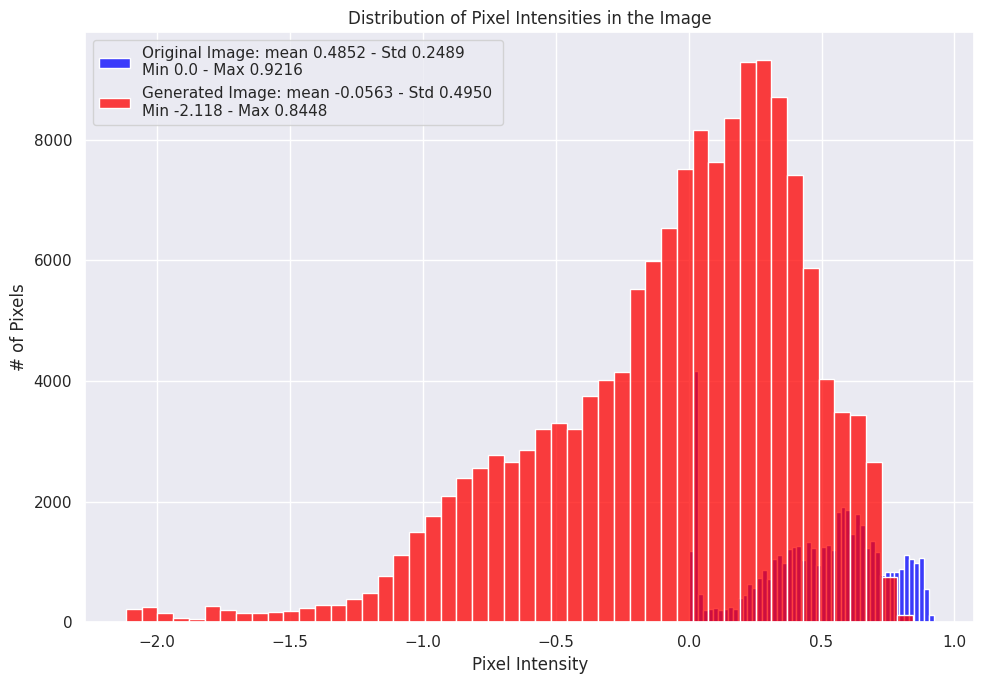

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get a single batch of images and labels
sample_batch, _ = next(train_generator)  # _ is the corresponding labels

# Choose a random image from the batch (we'll use the first image in the batch)
generated_image = sample_batch[0]

# Read the raw image using the path from 'train_df' to show the original
image_path = os.path.join(IMAGE_DIR, train_df['Image Index'].iloc[0])
raw_image = plt.imread(image_path)

# Plot histograms of pixel distributions
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for the original image
sns.histplot(raw_image.ravel(), 
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Std {np.std(raw_image):.4f} \n'
             f'Min {np.min(raw_image):.4} - Max {np.max(raw_image):.4}', 
             color='blue', 
             kde=False, bins=50)

# Plot histogram for the generated (preprocessed) image
sns.histplot(generated_image.ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image):.4f} - Std {np.std(generated_image):.4f} \n'
             f'Min {np.min(generated_image):.4} - Max {np.max(generated_image):.4}', 
             color='red', 
             kde=False, bins=50)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# of Pixels')

# Show the plot
plt.tight_layout()
plt.show()

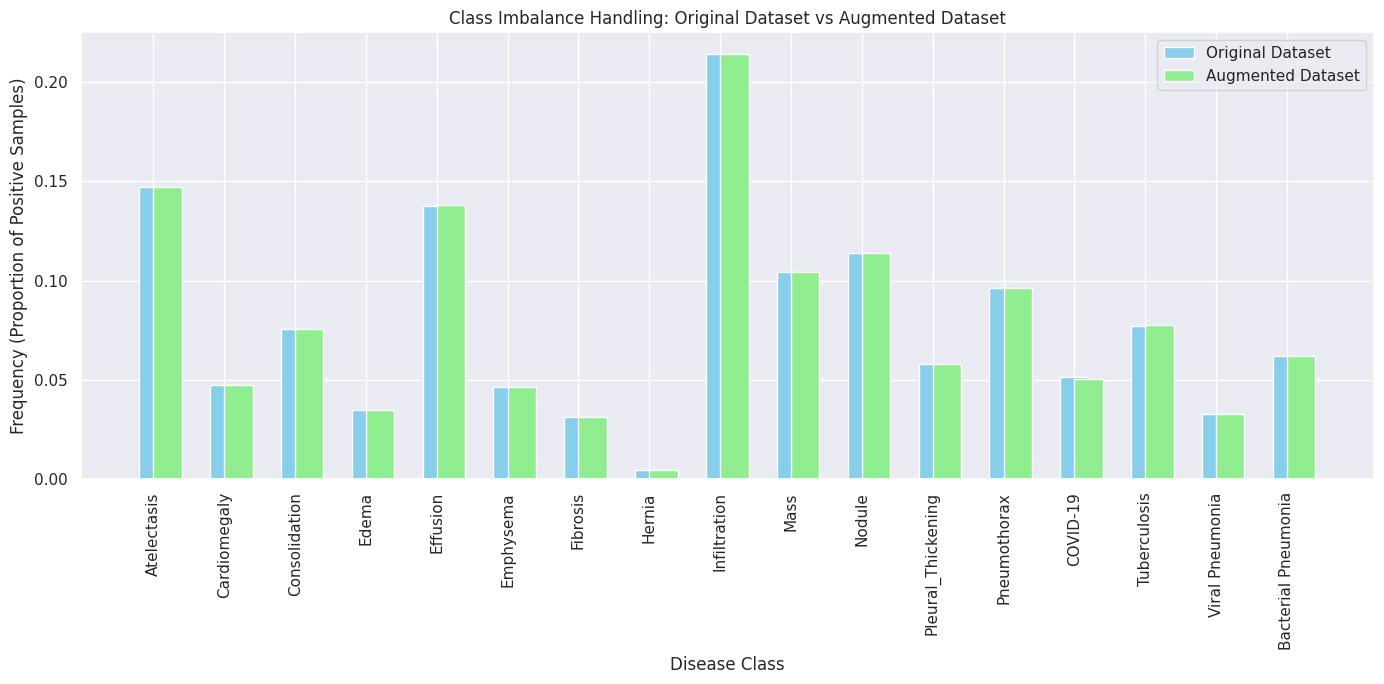

In [14]:
import numpy as np
import matplotlib.pyplot as plt


original_frequencies = np.mean(train_df[labels].values, axis=0)

# Calculate the frequencies of the classes from the train_generator
train_generator_frequencies = np.mean(train_generator.labels[:, :len(labels)], axis=0)

# Plotting comparison for class imbalance before and after augmentation
plt.figure(figsize=(14, 7))

# Plot original dataset class frequencies
plt.bar(labels, original_frequencies, width=0.4, label='Original Dataset', align='center', color='skyblue')

# Plot train_generator class frequencies
plt.bar(labels, train_generator_frequencies, width=0.4, label='Augmented Dataset', align='edge', color='lightgreen')

# Add labels and title
plt.title("Class Imbalance Handling: Original Dataset vs Augmented Dataset")
plt.xlabel("Disease Class")
plt.ylabel("Frequency (Proportion of Positive Samples)")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

## Base Model: DenseNet-169
DenseNet-169 is a variant of the DenseNet architecture, introduced by Gao Huang et al. in their 2018 paper titled "Densely Connected Convolutional Networks." It builds upon the concept of dense connections between layers, which helps improve the flow of gradients during training and facilitates more efficient feature reuse. DenseNet-169, as the name suggests, contains 169 layers in total, and it belongs to the family of Densely Connected Convolutional Networks (DenseNets).

### DenseNet Architecture:
In a DenseNet, each layer receives input not only from the previous layer but also from all preceding layers. This means that the first layer is connected to every other layer (2nd, 3rd, 4th, etc.), the second layer is connected to the 3rd, 4th, 5th, etc., and so on. This dense connection strategy is aimed at enhancing feature propagation and reducing the problem of vanishing gradients by allowing direct connections between layers.

In traditional convolutional networks, each layer learns features based only on the output of the previous layer. However, in DenseNet, each layer has direct access to the feature maps of all preceding layers. This connection strategy helps with better gradient flow, reduces overfitting, and improves the model's performance, especially for smaller datasets.

### Model Description for DenseNet-169:
In practice, DenseNet-169 can be used as a feature extractor for a variety of tasks, including classification, segmentation, and more. In transfer learning, you can take a pre-trained DenseNet-169 model and fine-tune it for your specific task, such as multi-label classification on chest X-ray images.

For a multi-label classification task like the one you're working on, here’s how DenseNet-169 can be extended:

#### Base Model (DenseNet-169):
You load the pre-trained DenseNet-169 model without the top classification layer. This means you can use it as a feature extractor and avoid training the convolutional layers from scratch. You set include_top=False to exclude the final classification layer and set weights='imagenet' to load pre-trained weights from ImageNet.

#### GlobalAveragePooling2D Layer:
After the DenseNet-169 base, you can add a GlobalAveragePooling2D layer. This layer computes the average of all the feature maps in the last convolutional block, converting the 3D output of the convolutional layers into a 1D feature vector that can be passed to the final classification layer.

#### Dense Layer with Sigmoid Activation:
You can then add a Dense layer with a sigmoid activation function. This layer will output a probability for each class in a multi-label classification task. The sigmoid activation ensures that each class is treated independently and the model can predict the presence or absence of each disease, where each output will be a value between 0 and 1.

### Model Summary:
#### Base Model:
DenseNet-169 (pre-trained on ImageNet, excluding the top classification layer). Input shape: (224, 224, 3), suitable for color images like chest X-rays.

#### Global Average Pooling:
Converts the spatial dimensions into a single vector, making the features compatible for the final classification layer.

#### Dense Layer:
A Dense layer with a number of output units equal to the number of diseases or classes in your multi-label classification task. Sigmoid activation: Used to output independent probability scores for each label (class), useful for multi-label classification.

In [15]:
from keras.applications import DenseNet169
from keras.optimizers import Adamax
from tensorflow.keras.metrics import AUC
from keras.models import Model
from keras.layers import Dense

def build_model():
    # Load the pre-trained DenseNet201 model
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    print("Loaded DenseNet 169")
    # Add new trainable layers on top of the pre-trained model
    x = base_model.output
    preds = Dense(len(labels), activation='sigmoid')(x)
    print("Added layers")
    # Create the final model
    model = Model(inputs=base_model.input, outputs=preds)

    # Create an Adam optimizer with weight decay
    optimizer = Adamax(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy', AUC(name='auc')])
    print("Compiled Model")
    
    return model

In [16]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [17]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_model()


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded DenseNet 169
Added layers
Compiled Model


In [18]:
multi_gpu_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 12,671,185 (48.34 MB)

 Trainable params: 12,512,785 (47.73 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [19]:
# Print out the total number of layers
layers_ = multi_gpu_model.layers
print('total number of layers =',len(layers_))

total number of layers = 597


## Training

In [20]:
weights_path = '/kaggle/working/Model-1_epoch.weights.h5'
model_save_path = '/kaggle/working/full_model.h5' 

import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
checkpoint_path_val_loss = 'model/DenseNet169_val_loss.keras'
checkpoint_path_val_AUC= 'model/DenseNet169_val_AUC.keras'


checkpoint_dir = os.path.dirname(checkpoint_path_val_loss)

# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks

checkpoint_val_loss = ModelCheckpoint(checkpoint_path_val_loss, verbose=0, save_best_only=True)
checkpoint_val_AUC = ModelCheckpoint(checkpoint_path_val_AUC, verbose=0, save_best_only=True, monitor='val_AUC', mode='max')


anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [ ]:
# 5. Train the model using the TPU strategy
history = multi_gpu_model.fit(
    train_generator,  # Train data generator (ensure you have defined it correctly)
    epochs=30,  # Number of epochs (you can increase this)
    steps_per_epoch=800,  # Steps per epoch
    callbacks=[anne, early_stopping,checkpoint_val_loss, checkpoint_val_AUC],  # Callbacks for training
    validation_data=val_generator,  # Validation data generator (ensure it's defined)
)


multi_gpu_model.save_weights(weights_path)  # Saving weights after training the current epoch
multi_gpu_model.save(model_save_path)  # Save full model (architecture + weights)

Epoch 1/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 1112s 985ms/step - auc: 0.8451 - binary_accuracy: 0.9220 - loss: 0.2116 - val_auc: 0.8416 - val_binary_accuracy: 0.9224 - val_loss: 0.2272 - learning_rate: 0.0010

Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 606s 750ms/step - auc: 0.9002 - binary_accuracy: 0.9334 - loss: 0.1763 - val_auc: 0.8871 - val_binary_accuracy: 0.9325 - val_loss: 0.1859 - learning_rate: 0.0010

Epoch 3/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 614s 759ms/step - auc: 0.9103 - binary_accuracy: 0.9347 - loss: 0.1696 - val_auc: 0.7689 - val_binary_accuracy: 0.9156 - val_loss: 0.3022 - learning_rate: 0.0010

Epoch 4/30
496/800 ━━━━━━━━━━━━━━━━━━━━ 5:49 1s/step - auc: 0.9169 - binary_accuracy: 0.9360 - loss: 0.1643
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

800/800 ━━━━━━━━━━━━━━━━━━━━ 616s 762ms/step - auc: 0.9166 - binary_accuracy: 0.9361 - loss: 0.1645 - val_auc: 0.8543 - val_binary_accuracy: 0.9249 - val_loss: 0.2221 - learning_rate: 0.0010

Epoch 5/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 616s 761ms/step - auc: 0.9326 - binary_accuracy: 0.9406 - loss: 0.1511 - val_auc: 0.9057 - val_binary_accuracy: 0.9340 - val_loss: 0.1748 - learning_rate: 1.0000e-04

Epoch 6/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 606s 750ms/step - auc: 0.9417 - binary_accuracy: 0.9431 - loss: 0.1427 - val_auc: 0.8922 - val_binary_accuracy: 0.9310 - val_loss: 0.1917 - learning_rate: 1.0000e-04

Epoch 7/30
496/800 ━━━━━━━━━━━━━━━━━━━━ 5:48 1s/step - auc: 0.9462 - binary_accuracy: 0.9450 - loss: 0.1379
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

800/800 ━━━━━━━━━━━━━━━━━━━━ 614s 759ms/step - auc: 0.9462 - binary_accuracy: 0.9450 - loss: 0.1379 - val_auc: 0.8919 - val_binary_accuracy: 0.9319 - val_loss: 0.1906 - learning_rate: 1.0000e-04

Epoch 8/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 615s 760ms/step - auc: 0.9518 - binary_accuracy: 0.9474 - loss: 0.1320 - val_auc: 0.8894 - val_binary_accuracy: 0.9311 - val_loss: 0.1946 - learning_rate: 1.0000e-05

Epoch 9/30
496/800 ━━━━━━━━━━━━━━━━━━━━ 5:45 1s/step - auc: 0.9528 - binary_accuracy: 0.9477 - loss: 0.1309
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06
.
800/800 ━━━━━━━━━━━━━━━━━━━━ 609s 753ms/step - auc: 0.9528 - binary_accuracy: 0.9478 - loss: 0.1307 - val_auc: 0.8858 - val_binary_accuracy: 0.9295 - val_loss: 0.1996 - learning_rate: 1.0000e-05

Epoch 10/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 614s 759ms/step - auc: 0.9530 - binary_accuracy: 0.9476 - loss: 0.1306 - val_auc: 0.8927 - val_binary_accuracy: 0.9311 - val_loss: 0.1917 - learning_rate: 1.0000e-06

Epoch 11/30
496/800 ━━━━━━━━━━━━━━━━━━━━ 5:45 1s/step - auc: 0.9537 - binary_accuracy: 0.9481 - loss: 0.1302
Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

800/800 ━━━━━━━━━━━━━━━━━━━━ 609s 753ms/step - auc: 0.9537 - binary_accuracy: 0.9482 - loss: 0.1300 - val_auc: 0.8909 - val_binary_accuracy: 0.9308 - val_loss: 0.1945 - learning_rate: 1.0000e-06

Epoch 12/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 614s 760ms/step - auc: 0.9535 - binary_accuracy: 0.9482 - loss: 0.1297 - val_auc: 0.8883 - val_binary_accuracy: 0.9303 - val_loss: 0.1977 - learning_rate: 1.0000e-07

Epoch 13/30
496/800 ━━━━━━━━━━━━━━━━━━━━ 5:51 1s/step - auc: 0.9528 - binary_accuracy: 0.9478 - loss: 0.1304
Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.

800/800 ━━━━━━━━━━━━━━━━━━━━ 619s 765ms/step - auc: 0.9530 - binary_accuracy: 0.9478 - loss: 0.1301 - val_auc: 0.8928 - val_binary_accuracy: 0.9320 - val_loss: 0.1914 - learning_rate: 1.0000e-07

Epoch 14/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 619s 766ms/step - auc: 0.9533 - binary_accuracy: 0.9481 - loss: 0.1301 - val_auc: 0.8884 - val_binary_accuracy: 0.9308 - val_loss: 0.1961 - learning_rate: 1.0000e-07

Epoch 15/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 619s 766ms/step - auc: 0.9536 - binary_accuracy: 0.9479 - loss: 0.1301 - val_auc: 0.8903 - val_binary_accuracy: 0.9306 - val_loss: 0.1941 - learning_rate: 1.0000e-07

Epoch 16/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 611s 756ms/step - auc: 0.9534 - binary_accuracy: 0.9479 - loss: 0.1302 - val_auc: 0.8925 - val_binary_accuracy: 0.9312 - val_loss: 0.1932 - learning_rate: 1.0000e-07

Epoch 17/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 609s 753ms/step - auc: 0.9535 - binary_accuracy: 0.9479 - loss: 0.1301 - val_auc: 0.8903 - val_binary_accuracy: 0.9304 - val_loss: 0.1967 - learning_rate: 1.0000e-07

Epoch 18/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 605s 748ms/step - auc: 0.9535 - binary_accuracy: 0.9483 - loss: 0.1296 - val_auc: 0.8903 - val_binary_accuracy: 0.9300 - val_loss: 0.1956 - learning_rate: 1.0000e-07

Epoch 19/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 614s 759ms/step - auc: 0.9536 - binary_accuracy: 0.9484 - loss: 0.1297 - val_auc: 0.8869 - val_binary_accuracy: 0.9296 - val_loss: 0.1989 - learning_rate: 1.0000e-07

Epoch 20/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 611s 755ms/step - auc: 0.9534 - binary_accuracy: 0.9481 - loss: 0.1300 - val_auc: 0.8925 - val_binary_accuracy: 0.9313 - val_loss: 0.1934 - learning_rate: 1.0000e-07

Epoch 21/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 611s 754ms/step - auc: 0.9536 - binary_accuracy: 0.9479 - loss: 0.1300 - val_auc: 0.8909 - val_binary_accuracy: 0.9319 - val_loss: 0.1936 - learning_rate: 1.0000e-07

Epoch 22/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 609s 753ms/step - auc: 0.9539 - binary_accuracy: 0.9480 - loss: 0.1297 - val_auc: 0.8949 - val_binary_accuracy: 0.9306 - val_loss: 0.1930 - learning_rate: 1.0000e-07

Epoch 23/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 612s 756ms/step - auc: 0.9533 - binary_accuracy: 0.9481 - loss: 0.1301 - val_auc: 0.8912 - val_binary_accuracy: 0.9311 - val_loss: 0.1934 - learning_rate: 1.0000e-07

Epoch 24/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 614s 759ms/step - auc: 0.9537 - binary_accuracy: 0.9480 - loss: 0.1299 - val_auc: 0.8929 - val_binary_accuracy: 0.9324 - val_loss: 0.1911 - learning_rate: 1.0000e-07

Epoch 25/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 617s 763ms/step - auc: 0.9535 - binary_accuracy: 0.9479 - loss: 0.1300 - val_auc: 0.8904 - val_binary_accuracy: 0.9311 - val_loss: 0.1958 - learning_rate: 1.0000e-07

Epoch 26/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 617s 762ms/step - auc: 0.9538 - binary_accuracy: 0.9481 - loss: 0.1296 - val_auc: 0.8913 - val_binary_accuracy: 0.9317 - val_loss: 0.1929 - learning_rate: 1.0000e-07

Epoch 27/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 615s 760ms/step - auc: 0.9539 - binary_accuracy: 0.9483 - loss: 0.1294 - val_auc: 0.8890 - val_binary_accuracy: 0.9308 - val_loss: 0.1960 - learning_rate: 1.0000e-07

Epoch 28/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 608s 751ms/step - auc: 0.9534 - binary_accuracy: 0.9481 - loss: 0.1300 - val_auc: 0.8917 - val_binary_accuracy: 0.9309 - val_loss: 0.1946 - learning_rate: 1.0000e-07

Epoch 29/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 611s 755ms/step - auc: 0.9531 - binary_accuracy: 0.9478 - loss: 0.1304 - val_auc: 0.8899 - val_binary_accuracy: 0.9306 - val_loss: 0.1956 - learning_rate: 1.0000e-07

Epoch 30/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 614s 759ms/step - auc: 0.9538 - binary_accuracy: 0.9482 - loss: 0.1297 - val_auc: 0.8952 - val_binary_accuracy: 0.9329 - val_loss: 0.1885 - learning_rate: 1.0000e-07

In [21]:
 model = load_model('/kaggle/input/model9/DenseNet169 -17_val_loss.keras')

## Prediction and Evaluation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Update the train generator with the high batch size
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"
# Smaller batch size to fit within memory constraints
batch_size = 512

# Adjust the test generator with the new batch size and directory
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image  # Custom preprocessing function
).flow_from_dataframe(
    dataframe=test_df,  # Use the test DataFrame
    directory=IMAGE_DIR,  # Use the image directory for test images
    x_col='Image Index',  # Correcting x_col to 'full_path' for image paths in your dataset
    y_col=labels,
    target_size=(224, 224),  # Resize images to 224x224
    color_mode='rgb',  # Load images in RGB color mode
    class_mode='raw',  # Multi-output, raw labels (binary vector for each image)
    batch_size=batch_size,  # Batch size
    shuffle=False  # Ensure data order is consistent for evaluation
)

Found 6794 validated image filenames.


###  Generate AUC ROC

In [24]:
# Initialize arrays to store predictions and true labels
y_preds = []
y_trues = []

# Iterate over the test generator and collect predictions
for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred_batch = model.predict(x_batch, verbose =0)
    y_preds.append(y_pred_batch)
    y_trues.append(y_batch)

In [25]:
# Compute the ROC AUC score for each class
# Concatenate all batches together
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)

# Extract class labels from the dataframe columns
class_labels = test_df[labels].columns
# Compute the ROC AUC score for each class
roc_auc_scores = {}
for i, label in enumerate(class_labels):
    auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
    roc_auc_scores[label] = auc

# Print the ROC AUC scores
for label, auc in roc_auc_scores.items():
    print(f"ROC AUC Score for {label}: {auc:.4f}")

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

ROC AUC Score for Atelectasis: 0.8150
ROC AUC Score for Cardiomegaly: 0.9144
ROC AUC Score for Consolidation: 0.7701
ROC AUC Score for Edema: 0.9027
ROC AUC Score for Effusion: 0.8616
ROC AUC Score for Emphysema: 0.9241
ROC AUC Score for Fibrosis: 0.8525
ROC AUC Score for Hernia: 0.8327
ROC AUC Score for Infiltration: 0.7699
ROC AUC Score for Mass: 0.8492
ROC AUC Score for Nodule: 0.7978
ROC AUC Score for Pleural_Thickening: 0.7924
ROC AUC Score for Pneumothorax: 0.8980
ROC AUC Score for COVID-19: 0.9964
ROC AUC Score for Tuberculosis: 1.0000
ROC AUC Score for Viral Pneumonia: 0.9886
ROC AUC Score for Bacterial Pneumonia: 0.9939
Average ROC AUC Score: 0.8800


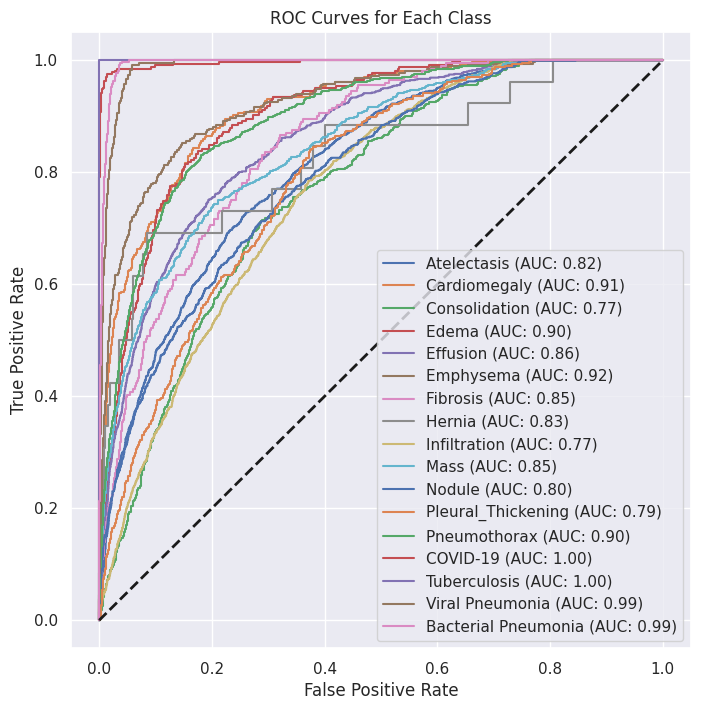

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_trues and y_preds are already defined
# class_labels should be a list of class names

# Plot ROC curves for each class
fig, c_ax = plt.subplots(1, 1, figsize=(8, 8))
for (idx, c_label) in enumerate(class_labels):
    fpr, tpr, thresholds = roc_curve(y_trues[:, idx], y_preds[:, idx])
    auc_score = auc(fpr, tpr)
    c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc_score:.2f})')

# Plotting the diagonal line
c_ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curves for Each Class')
c_ax.legend(loc='best')

# Save the figure
fig.savefig('ROC Curves.png')
plt.show()

### Compute the ROC AUC score (micro-average)

Micro-Average ROC AUC Score: 0.9088


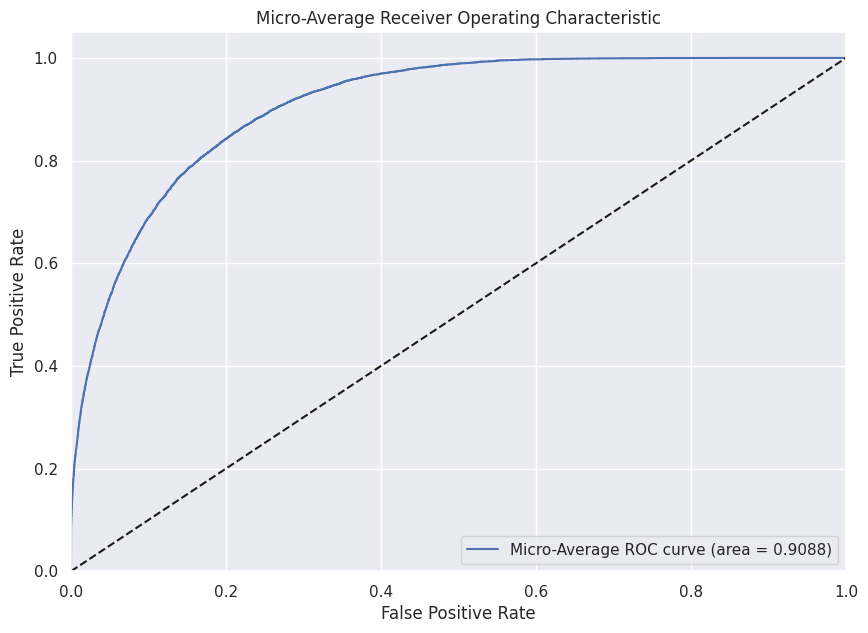

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute the ROC AUC score (micro-average)
roc_auc_micro = roc_auc_score(y_trues, y_preds, average='micro')
print(f"Micro-Average ROC AUC Score: {roc_auc_micro:.4f}")

# Compute the ROC curve (micro-average)
fpr, tpr, _ = roc_curve(y_trues.ravel(), y_preds.ravel())

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Micro-Average ROC curve (area = {roc_auc_micro:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Save the figure
plt.savefig('Micro-Average-ROC.png', bbox_inches='tight')

## Confusion_Matrix

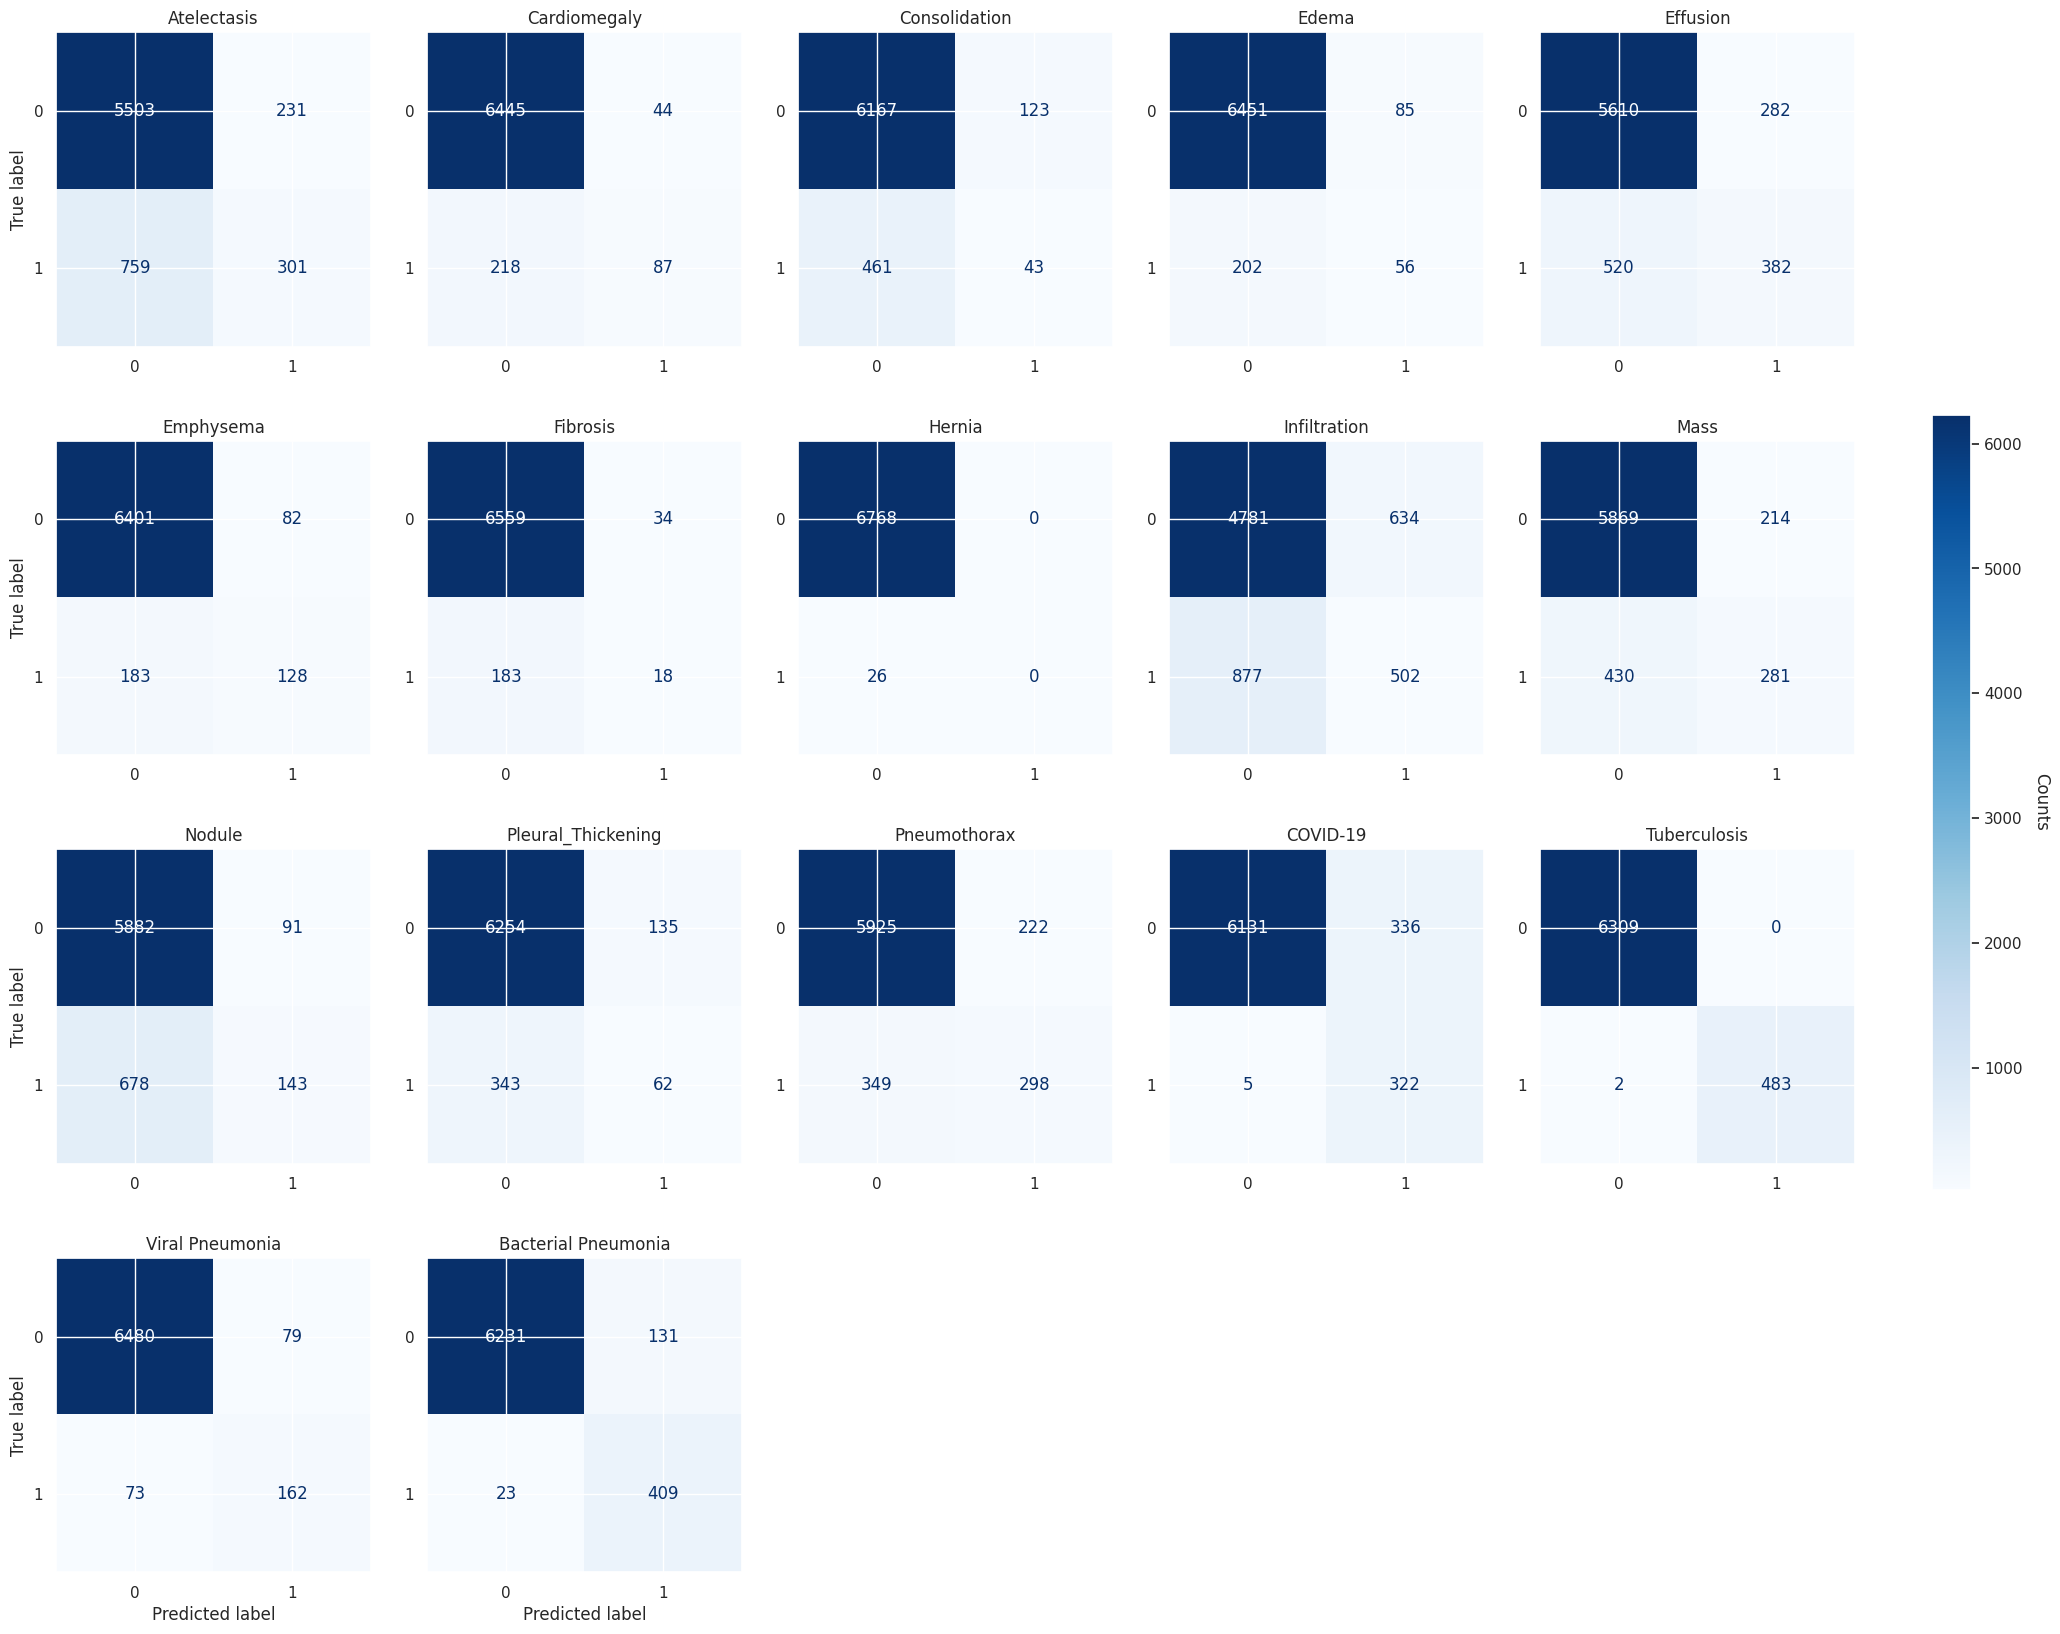

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Assume `y_preds`, `y_trues`, and `labels` are defined
y_pred = (y_preds > 0.4).astype(int)
y_true = y_trues

# Calculate the confusion matrix for each label
cm = multilabel_confusion_matrix(y_true, y_pred)

# Set the figure size and create subplots
rows = 4  # Number of rows for the plot grid
cols = 5  # Number of columns for the plot grid (4x5=20 > 17, leaving extra space)
f, axes = plt.subplots(rows, cols, figsize=(25, 20))  # Adjusted size for 17 plots
axes = axes.ravel()

# Loop through each class label
for i in range(len(labels)):
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]),
                                  display_labels=[0, 1])  # Assuming binary labels (0, 1)
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')
    disp.ax_.set_title(labels[i])

    # Adjust axis labels
    if i < (rows - 1) * cols:
        disp.ax_.set_xlabel('')
    if i % cols != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()  # Remove the individual colorbar

# Turn off unused axes
for j in range(len(labels), rows * cols):
    f.delaxes(axes[j])

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.10, hspace=0.3)

# Add a single, shared colorbar
cbar = f.colorbar(disp.im_, ax=axes, location='right', fraction=0.02, pad=0.04)
cbar.ax.set_ylabel('Counts', rotation=270, labelpad=20)

# Save the plot as a PNG file
plt.savefig('confusion_matrix_17_diseases.png', bbox_inches='tight')
plt.show()


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
y_pred_classes = np.where(y_preds > 0.4, 1, 0)  # Assuming binary classification

In [30]:
# Initialize dictionaries to hold scores per class
precision_scores = {}
recall_scores = {}
f1_scores = {}
accuracy_scores = {}

# Extract class labels from the dataframe columns
class_labels = test_df[labels].columns

for i, label in enumerate(class_labels):
    precision = precision_score(y_trues[:, i], y_pred_classes[:, i])
    recall = recall_score(y_trues[:, i], y_pred_classes[:, i])
    f1 = f1_score(y_trues[:, i], y_pred_classes[:, i])
    accuracy = accuracy_score(y_trues[:, i], y_pred_classes[:, i])
    
    # Store the scores
    precision_scores[label] = precision
    recall_scores[label] = recall
    f1_scores[label] = f1
    accuracy_scores[label] = accuracy

# Print the metrics for each class
for label in class_labels:
    print(f"{label} - Precision: {precision_scores[label]:.4f}, Recall: {recall_scores[label]:.4f}, F1 Score: {f1_scores[label]:.4f}, Accuracy: {accuracy_scores[label]:.4f}")

# Calculate and print the average accuracy across all classes
average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)
print(f"\nAverage Accuracy across all classes: {average_accuracy:.4f}")


Atelectasis - Precision: 0.5658, Recall: 0.2840, F1 Score: 0.3781, Accuracy: 0.8543
Cardiomegaly - Precision: 0.6641, Recall: 0.2852, F1 Score: 0.3991, Accuracy: 0.9614
Consolidation - Precision: 0.2590, Recall: 0.0853, F1 Score: 0.1284, Accuracy: 0.9140
Edema - Precision: 0.3972, Recall: 0.2171, F1 Score: 0.2807, Accuracy: 0.9578
Effusion - Precision: 0.5753, Recall: 0.4235, F1 Score: 0.4879, Accuracy: 0.8820
Emphysema - Precision: 0.6095, Recall: 0.4116, F1 Score: 0.4914, Accuracy: 0.9610
Fibrosis - Precision: 0.3462, Recall: 0.0896, F1 Score: 0.1423, Accuracy: 0.9681
Hernia - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9962
Infiltration - Precision: 0.4419, Recall: 0.3640, F1 Score: 0.3992, Accuracy: 0.7776
Mass - Precision: 0.5677, Recall: 0.3952, F1 Score: 0.4660, Accuracy: 0.9052
Nodule - Precision: 0.6111, Recall: 0.1742, F1 Score: 0.2711, Accuracy: 0.8868
Pleural_Thickening - Precision: 0.3147, Recall: 0.1531, F1 Score: 0.2060, Accuracy: 0.9296
Pneumothorax

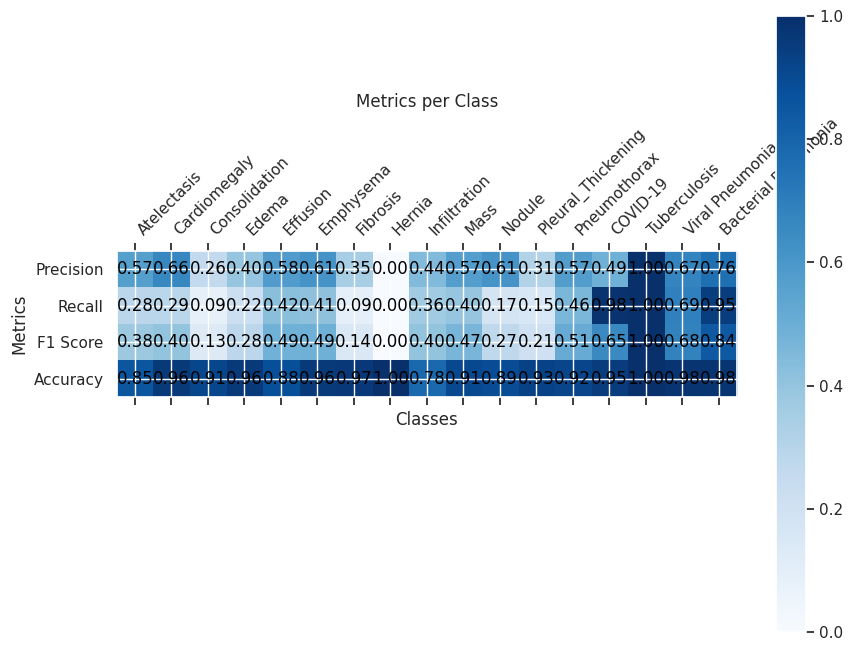

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming precision_scores, recall_scores, f1_scores, and accuracy_scores are already calculated

# Extract class labels from the dictionary keys
class_labels = list(precision_scores.keys())

# Combine all metrics into a single matrix
metrics_matrix = np.array([
    list(precision_scores.values()),
    list(recall_scores.values()),
    list(f1_scores.values()),
    list(accuracy_scores.values())
])

# Define the metric names
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Plotting the metrics in a matrix-style grid
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(metrics_matrix, cmap='Blues')

# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(metric_names)))

# Label the axes with class names and metric names
ax.set_xticklabels(class_labels, rotation=45, ha="left")
ax.set_yticklabels(metric_names)

# Loop over data dimensions and create text annotations
for i in range(len(metric_names)):
    for j in range(len(class_labels)):
        ax.text(j, i, f'{metrics_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Set titles and layout
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Metrics per Class')
fig.savefig('Metrics per Class.png')
plt.show()

In [32]:
avg_precision = np.mean(list(precision_scores.values()))
avg_recall = np.mean(list(recall_scores.values()))
avg_f1 = np.mean(list(f1_scores.values()))
avg_accuracy = np.mean(list(accuracy_scores.values()))

print(f"\nAverage Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")


Average Precision: 0.5203
Average Recall: 0.4094
Average F1 Score: 0.4315
Average Accuracy: 0.9303


## Interpreting Deep Learning Models

In [34]:
#  *********************************** Using Thresolding ************************************
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd

# Path to the images directory
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"

# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    # Normalize the image by scaling to [0, 1]
    img = img / 255.0
    
    # Subtract the mean and divide by the standard deviation (ImageNet values)
    img = (img - mean) / std
    
    return img

# Function to predict diseases for an image
def predict_disease_from_id(image_id, test_data):
    # Find the image row from the dataset using the image_id
    image_row = test_data[test_data['Image Index'] == image_id]
    
    # Check if the image exists in the dataset
    if image_row.empty:
        print(f"Image with ID {image_id} not found in the dataset.")
        return
    
    # Debugging: print the row to understand the data format
    print(f"Row for image {image_id}:")
    print(image_row)
    
    # Extract the ground truth (disease labels) from the row based on the 14 labels
    ground_truth = image_row[labels].values.astype(int).flatten()  # Flatten to make it 1D
    
    # Ensure ground_truth has the expected shape
    print(f"Ground truth array: {ground_truth}")
    
    # Check if ground_truth length matches the number of labels (14)
    if len(ground_truth) != len(labels):
        print(f"Mismatch in ground truth length. Expected {len(labels)} but got {len(ground_truth)}.")
        return

    # Load the image
    img_path = f"{IMAGE_DIR}/{image_id}"
    img = cv2.imread(img_path)
    
    # Check if the image exists
    if img is None:
        print(f"Image file {image_id} not found.")
        return
    
    # Resize image to match the model input size (224x224)
    img_resized = cv2.resize(img, (224, 224))  # Resize to 224x224
    
    # Preprocess the image using the custom preprocessing function
    img_preprocessed = preprocess_image(img_resized)
    
    # Predict the disease labels
    predictions = model.predict(np.expand_dims(img_preprocessed, axis=0))
    
    # Print the raw predictions (probabilities)
    print(f"Raw Predictions: {predictions}")
    
    # Define a threshold for classification (e.g., 0.5)
    threshold = 0.16

    # Create a list to store the diseases with their corresponding probabilities
    predicted_diseases = []
    
    # Iterate through all predicted probabilities
    for i, prob in enumerate(predictions[0]):
        if prob > threshold:  # If the probability is above the threshold
            predicted_diseases.append((labels[i], prob))  # Store the disease and its probability

    # Sort the diseases based on probability (highest first)
    predicted_diseases.sort(key=lambda x: x[1], reverse=True)
    
    # Extract the diseases and their probabilities
    predicted_diseases_names = [disease[0] for disease in predicted_diseases]
    predicted_diseases_probs = [disease[1] for disease in predicted_diseases]

    # Output the ground truth and predicted diseases with their probabilities
    ground_truth_diseases = [labels[i] for i, label in enumerate(ground_truth) if label == 1]

    print(f"Ground Truth: {', '.join(ground_truth_diseases) if ground_truth_diseases else 'No disease'}")
    print(f"Predicted Diseases: {', '.join(predicted_diseases_names) if predicted_diseases_names else 'No disease'}")
    
    # Optionally print the predicted diseases with their probabilities
    for disease, prob in zip(predicted_diseases_names, predicted_diseases_probs):
        print(f"Predicted {disease} with probability: {prob:.4f}")

# Example usage
image_id = "00018455_001.png"  # Replace with the actual image ID from your test dataset
predict_disease_from_id(image_id, test_df)

Row for image 00018455_001.png:
           Image Index  Atelectasis  Cardiomegaly  Consolidation  Edema  \
6401  00018455_001.png            0             0              0      0   

      Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
6401         0          0         0       0             1     0       0   

      Pleural_Thickening  Pneumothorax  COVID-19  Tuberculosis  \
6401                   0             0         0             0   

      Viral Pneumonia  Bacterial Pneumonia  
6401                0                    0  
Ground truth array: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw Predictions: [[1.4781309e-02 1.0451085e-03 2.6084242e-02 2.8184374e-04 3.7303944e-03
  1.9931488e-03 4.9850647e-03 1.6339592e-03 9.1584820e-01 3.4566797e-02
  6.5694645e-02 5.4313090e-02 8.0811530e-03 1.8681175e-04 3.1963451e-04
  1.8980193e-04 1.5883798e-04]]
Ground Truth: Infiltration
Predicted Diseases: Infiltration
Predicted Infiltration wit

In [35]:
#******************************************** Without Thresolding ************************************
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd

# Path to the images directory
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"

# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    # Normalize the image by scaling to [0, 1]
    img = img / 255.0
    
    # Subtract the mean and divide by the standard deviation (ImageNet values)
    img = (img - mean) / std
    
    return img

# Function to predict diseases for a single image
def predict_disease_from_id(image_id, test_data):
    # Find the image row from the dataset using the image_id
    image_row = test_data[test_data['Image Index'] == image_id]
    
    # Check if the image exists in the dataset
    if image_row.empty:
        print(f"Image with ID {image_id} not found in the dataset.")
        return
    
    # Extract the ground truth (disease labels) from the row based on the 14 labels
    ground_truth = image_row[labels].values.astype(int).flatten()  # Flatten to make it 1D
    
    # Ensure ground_truth has the expected shape
    print(f"Ground truth array: {ground_truth}")
    
    # Check if ground_truth length matches the number of labels (14)
    if len(ground_truth) != len(labels):
        print(f"Mismatch in ground truth length. Expected {len(labels)} but got {len(ground_truth)}.")
        return

    # Load the image
    img_path = f"{IMAGE_DIR}/{image_id}"
    img = cv2.imread(img_path)
    
    # Check if the image exists
    if img is None:
        print(f"Image file {image_id} not found.")
        return
    
    # Resize image to match the model input size (224x224)
    img_resized = cv2.resize(img, (224, 224))  # Resize to 224x224
    
    # Preprocess the image using the custom preprocessing function
    img_preprocessed = preprocess_image(img_resized)
    
    # Predict the disease labels
    predictions = model.predict(np.expand_dims(img_preprocessed, axis=0))  # Make prediction for one image
    
    # Print the raw predictions (probabilities)
    print(f"Raw Predictions: {predictions}")
    
    # Create a list to store the diseases with their corresponding probabilities
    predicted_diseases = []
    
    # Iterate through all predicted probabilities
    for i, prob in enumerate(predictions[0]):
        predicted_diseases.append((labels[i], prob))  # Store the disease and its probability

    # Sort the diseases based on probability (highest first)
    predicted_diseases.sort(key=lambda x: x[1], reverse=True)
    
    # Extract the diseases and their probabilities
    predicted_diseases_names = [disease[0] for disease in predicted_diseases]
    predicted_diseases_probs = [disease[1] for disease in predicted_diseases]

    # Output the ground truth and predicted diseases with their probabilities
    ground_truth_diseases = [labels[i] for i, label in enumerate(ground_truth) if label == 1]

    print(f"Ground Truth: {', '.join(ground_truth_diseases) if ground_truth_diseases else 'No disease'}")
    print(f"Predicted Diseases: {', '.join(predicted_diseases_names) if predicted_diseases_names else 'No disease'}")
    
    # Optionally print the predicted diseases with their probabilities
    for disease, prob in zip(predicted_diseases_names, predicted_diseases_probs):
        print(f"Predicted {disease} with probability: {prob:.4f}")

# Example usage
image_id = "00018455_001.png"  # Replace with the actual image ID from your test dataset
predict_disease_from_id(image_id, test_df)

Ground truth array: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Raw Predictions: [[1.4781309e-02 1.0451085e-03 2.6084242e-02 2.8184374e-04 3.7303944e-03
  1.9931488e-03 4.9850647e-03 1.6339592e-03 9.1584820e-01 3.4566797e-02
  6.5694645e-02 5.4313090e-02 8.0811530e-03 1.8681175e-04 3.1963451e-04
  1.8980193e-04 1.5883798e-04]]
Ground Truth: Infiltration
Predicted Diseases: Infiltration, Nodule, Pleural_Thickening, Mass, Consolidation, Atelectasis, Pneumothorax, Fibrosis, Effusion, Emphysema, Hernia, Cardiomegaly, Tuberculosis, Edema, Viral Pneumonia, COVID-19, Bacterial Pneumonia
Predicted Infiltration with probability: 0.9158
Predicted Nodule with probability: 0.0657
Predicted Pleural_Thickening with probability: 0.0543
Predicted Mass with probability: 0.0346
Predicted Consolidation with probability: 0.0261
Predicted Atelectasis with probability: 0.0148
Predicted Pneumothorax with probability: 0.0081
Predicted Fibrosis with probability: 0.0050
Predicted E

## Implementing GradCAM
GradCAM is a technique to visualize the impact of each region of an image on a specific output for a Convolutional Neural Network model. Through GradCAM, we can generate a heatmap by computing gradients of the specific class scores we are interested in visualizing.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Diseases and Probabilities:
Infiltration: 91.58%
Nodule: 6.57%
Pleural_Thickening: 5.43%
Mass: 3.46%
Consolidation: 2.61%
Atelectasis: 1.48%
Pneumothorax: 0.81%


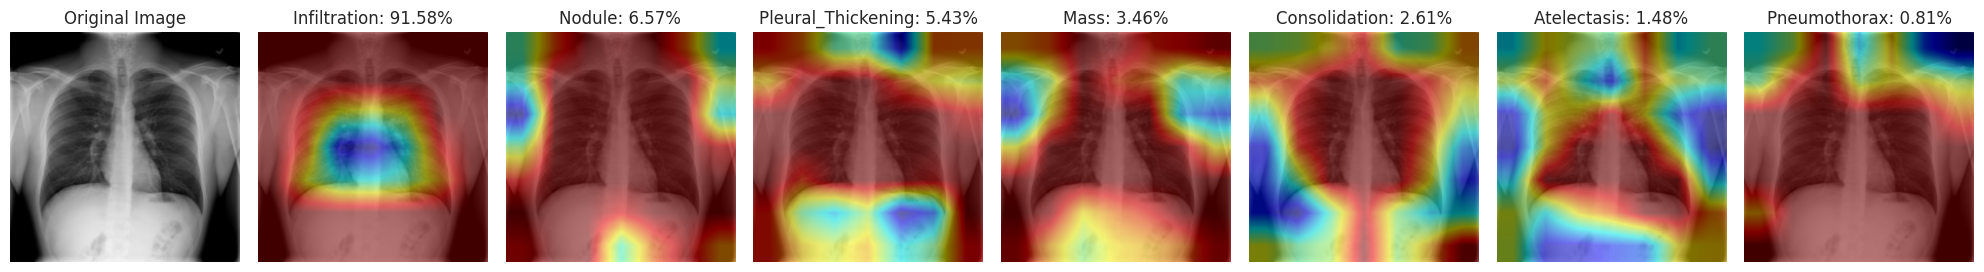

In [36]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam(model, img_array, class_idx, layer_name="conv5_block16_concat"):
    """
    Generate the GradCAM heatmap for a specific class index and layer.
    """
    grad_model = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        tape.watch(img_array)
        conv_output, predictions = grad_model(img_array)
        class_output = predictions[:, class_idx]
    
    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    heatmap = tf.reduce_sum(tf.multiply(conv_output, pooled_grads), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()

def predict_and_generate_gradcam(image_id, test_data, top_n=14):
    image_row = test_data[test_data['Image Index'] == image_id]
    if image_row.empty:
        print(f"Image with ID {image_id} not found.")
        return

    ground_truth = image_row[labels].values.astype(int).flatten()
    img_path = f"{IMAGE_DIR}/{image_id}"
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image file {image_id} not found.")
        return

    img_resized = cv2.resize(img, (224, 224))
    img_preprocessed = preprocess_image(img_resized)
    predictions = model.predict(tf.expand_dims(img_preprocessed, axis=0))

    # Get all the disease predictions
    probs = predictions[0]
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]

    # Print predicted diseases with their probabilities
    print("Predicted Diseases and Probabilities:")
    for i in range(top_n):
        print(f"{sorted_labels[i]}: {sorted_probs[i] * 100:.2f}%")

    # Plot the images and Grad-CAM overlays in a 2x7 grid
    plt.figure(figsize=(20, 14))  # Adjust the figure size for 14 plots
    plt.subplot(2, 8, 1)  # First subplot
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title("Original Image")

    for i in range(top_n):
        gradcam = grad_cam(model, tf.expand_dims(img_preprocessed, axis=0), sorted_indices[i])
        gradcam_resized = cv2.resize(gradcam, (224, 224), interpolation=cv2.INTER_LINEAR)
        overlay = np.uint8(255 * gradcam_resized)
        heatmap = cv2.applyColorMap(overlay, cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255.0

        img_resized_float = np.float32(img_resized) / 255.0
        blended_img = 0.5 * img_resized_float + 0.5 * heatmap

        plt.subplot(2, 8, i + 2)  # Create subplots in a 2x7 grid
        plt.imshow(blended_img)
        plt.axis('off')
        plt.title(f"{sorted_labels[i]}: {sorted_probs[i] * 100:.2f}%")

    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()

# Example usage
predict_and_generate_gradcam(image_id="00018455_001.png", test_data=test_df, top_n=7)